<a href="https://colab.research.google.com/github/AideenByrne/CA683i-/blob/main/CA683_Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Sentiment Analysis Using Rotten Tomatoes Movie Reviews
## CA683i Group 8

In [39]:
from google.colab import drive
import os
drive.mount('/content/drive/', force_remount=True)
os.chdir('/content/drive/My Drive/CA683 Assignment')
!ls

Mounted at /content/drive/
'Multiclass ROC.png'   test.tsv   train.tsv


In [40]:
##importing necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import svm

##reading data from .csv files to Pandas dataframes
train = pd.read_csv('train.tsv', sep='\t')
test = pd.read_csv('test.tsv', sep='\t')

In [41]:
!pip install textblob

In [42]:
!python -m textblob.download_corpora

[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Package brown is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package conll2000 to /root/nltk_data...
[nltk_data]   Package conll2000 is already up-to-date!
[nltk_data] Downloading package movie_reviews to /root/nltk_data...
[nltk_data]   Package movie_reviews is already up-to-date!
Finished.


## Exploratory Data Analysis

In [43]:
train.head()

,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,A series of escapades demonstrating the adage ...,1
1,2,1,A series of escapades demonstrating the adage ...,2
2,3,1,A series,2
3,4,1,A,2
4,5,1,series,2


In [44]:
train.describe()
#no missing values

,PhraseId,SentenceId,Sentiment
count,156060.000000,156060.000000,156060.000000
mean,78030.500000,4079.732744,2.063578
std,45050.785842,2502.764394,0.893832
min,1.000000,1.000000,0.000000
25%,39015.750000,1861.750000,2.000000
50%,78030.500000,4017.000000,2.000000
75%,117045.250000,6244.000000,3.000000
max,156060.000000,8544.000000,4.000000


In [45]:
test.describe()
#no missing values

,PhraseId,SentenceId
count,66292.00000,66292.000000
mean,189206.50000,10114.909144
std,19136.99636,966.787807
min,156061.00000,8545.000000
25%,172633.75000,9266.000000
50%,189206.50000,10086.000000
75%,205779.25000,10941.000000
max,222352.00000,11855.000000


2    79582
3    32927
1    27273
4     9206
0     7072
Name: Sentiment, dtype: int64

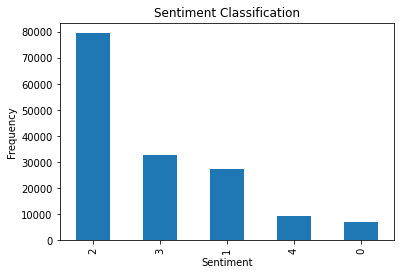

In [46]:
pd.value_counts(train['Sentiment']).plot.bar()
plt.title('Sentiment Classification')
plt.xlabel('Sentiment')
plt.ylabel('Frequency')
train['Sentiment'].value_counts()

In [47]:
def label_id(id):
    label_id_dict = {
        0: 'Negative',
        1: 'Somewhat Negative',
        2: 'Neutral',
        3: 'Somewhat Positive',
        4: 'Positive'
    }
    return label_id_dict[id]
train['Sentiment Label'] = list(map(label_id, train['Sentiment']))
train.head()

,PhraseId,SentenceId,Phrase,Sentiment,Sentiment Label
0,1,1,A series of escapades demonstrating the adage ...,1,Somewhat Negative
1,2,1,A series of escapades demonstrating the adage ...,2,Neutral
2,3,1,A series,2,Neutral
3,4,1,A,2,Neutral
4,5,1,series,2,Neutral


In [48]:
#to summarise the distribution of sentiment class
train["Sentiment Label"].value_counts()

Neutral              79582
Somewhat Positive    32927
Somewhat Negative    27273
Positive              9206
Negative              7072
Name: Sentiment Label, dtype: int64

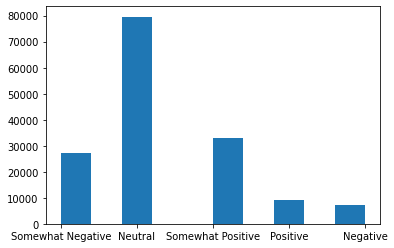

In [49]:
plt.hist(train['Sentiment Label'])
plt.show()

In [50]:
#investigating full phrase sentences and their sentiment label by removing duplicate sentence IDs
analysetrain = train.drop_duplicates(subset=['SentenceId'])
analysetrain

,PhraseId,SentenceId,Phrase,Sentiment,Sentiment Label
0,1,1,A series of escapades demonstrating the adage ...,1,Somewhat Negative
63,64,2,"This quiet , introspective and entertaining in...",4,Positive
81,82,3,"Even fans of Ismail Merchant 's work , I suspe...",1,Somewhat Negative
116,117,4,A positively thrilling combination of ethnogra...,3,Somewhat Positive
156,157,5,Aggressive self-glorification and a manipulati...,1,Somewhat Negative
...,...,...,...,...,...
155984,155985,8540,... either you 're willing to go with this cla...,2,Neutral
155997,155998,8541,"Despite these annoyances , the capable Claybur...",2,Neutral
156021,156022,8542,-LRB- Tries -RRB- to parody a genre that 's al...,1,Somewhat Negative
156031,156032,8543,The movie 's downfall is to substitute plot fo...,1,Somewhat Negative


In [51]:
## creating unique dataframes for each sentiment label to plot histograms of phrase length and explore text attributed to each sentiment
pos = analysetrain.loc[analysetrain['Sentiment'] == 4] #selecting data catalogued  as having a positive sentiment
positive = pd.DataFrame(pos) #converting this slice to a dataframe
neg = analysetrain.loc[analysetrain['Sentiment'] == 0]
negative = pd.DataFrame(neg)
neu = analysetrain.loc[analysetrain['Sentiment'] == 2]
neutral = pd.DataFrame(neu)
swneg = analysetrain.loc[analysetrain['Sentiment'] == 1]
somewhatneg = pd.DataFrame(swneg)
swpos = analysetrain.loc[analysetrain['Sentiment'] == 3]
somewhatpos = pd.DataFrame(swpos)

In [52]:
pos

,PhraseId,SentenceId,Phrase,Sentiment,Sentiment Label
63,64,2,"This quiet , introspective and entertaining in...",4,Positive
166,167,6,A comedy-drama of nearly epic proportions root...,4,Positive
352,353,13,The performances are an absolute joy .,4,Positive
551,552,21,"Best indie of the year , so far .",4,Positive
1164,1165,43,If a horror movie 's primary goal is to fright...,4,Positive
...,...,...,...,...,...
155325,155326,8502,Mike Leigh populates his movie with a wonderfu...,4,Positive
155527,155528,8513,"A gracious , eloquent film that by its end off...",4,Positive
155570,155571,8515,"It 's the kind of movie that , aside from Robe...",4,Positive
155593,155594,8516,"Williams creates a stunning , Taxi Driver-esqu...",4,Positive


In [53]:
neg

,PhraseId,SentenceId,Phrase,Sentiment,Sentiment Label
848,849,32,"Hampered -- no , paralyzed -- by a self-indulg...",0,Negative
1023,1024,38,The movie 's progression into rambling incoher...,0,Negative
1099,1100,41,Tartakovsky 's team has some freakish powers o...,0,Negative
1445,1446,53,"Thanks largely to Williams , all the interesti...",0,Negative
1479,1480,54,"Comes across as a relic from a bygone era , an...",0,Negative
...,...,...,...,...,...
155175,155176,8495,Disgusting .,0,Negative
155277,155278,8500,Crossroads feels like a teenybopper Ed Wood fi...,0,Negative
155427,155428,8508,As exciting as all this exoticism might sound ...,0,Negative
155556,155557,8514,Every conceivable mistake a director could mak...,0,Negative


In [54]:
neu

,PhraseId,SentenceId,Phrase,Sentiment,Sentiment Label
473,474,18,Like a less dizzily gorgeous companion to Mr. ...,2,Neutral
536,537,20,It 's everything you 'd expect -- but nothing ...,2,Neutral
647,648,24,That the Chuck Norris `` grenade gag '' occurs...,2,Neutral
686,687,25,The plot is romantic comedy boilerplate from s...,2,Neutral
702,703,26,"It arrives with an impeccable pedigree , mongr...",2,Neutral
...,...,...,...,...,...
155764,155765,8526,The Santa Clause 2 is a barely adequate babysi...,2,Neutral
155836,155837,8531,Even if you have no interest in the gang-infes...,2,Neutral
155984,155985,8540,... either you 're willing to go with this cla...,2,Neutral
155997,155998,8541,"Despite these annoyances , the capable Claybur...",2,Neutral


In [55]:
swpos

,PhraseId,SentenceId,Phrase,Sentiment,Sentiment Label
116,117,4,A positively thrilling combination of ethnogra...,3,Somewhat Positive
213,214,8,"The Importance of Being Earnest , so thick wit...",3,Somewhat Positive
363,364,14,Fresnadillo has something serious to say about...,3,Somewhat Positive
407,408,15,"I still like Moonlight Mile , better judgment ...",3,Somewhat Positive
423,424,16,A welcome relief from baseball movies that try...,3,Somewhat Positive
...,...,...,...,...,...
155802,155803,8528,It makes you believe the cast and crew thoroug...,3,Somewhat Positive
155818,155819,8529,The underworld urban angst is derivative of Ma...,3,Somewhat Positive
155876,155877,8533,Proves a servicable World War II drama that ca...,3,Somewhat Positive
155930,155931,8537,Definitely in the guilty pleasure B-movie cate...,3,Somewhat Positive


In [56]:
swneg

,PhraseId,SentenceId,Phrase,Sentiment,Sentiment Label
0,1,1,A series of escapades demonstrating the adage ...,1,Somewhat Negative
81,82,3,"Even fans of Ismail Merchant 's work , I suspe...",1,Somewhat Negative
156,157,5,Aggressive self-glorification and a manipulati...,1,Somewhat Negative
198,199,7,"Narratively , Trouble Every Day is a plodding ...",1,Somewhat Negative
247,248,9,But it does n't leave you with much .,1,Somewhat Negative
...,...,...,...,...,...
155900,155901,8534,This movie ... does n't deserve the energy it ...,1,Somewhat Negative
155911,155912,8535,In this case zero .,1,Somewhat Negative
155914,155915,8536,"Simply put , there should have been a more com...",1,Somewhat Negative
156021,156022,8542,-LRB- Tries -RRB- to parody a genre that 's al...,1,Somewhat Negative


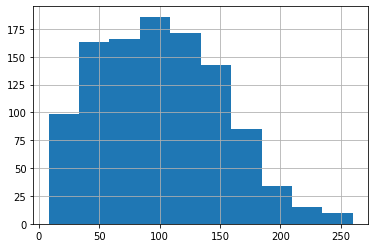

In [57]:
#histogram to display length of phrases in negative dataset
negative['Phrase'].str.len().hist()

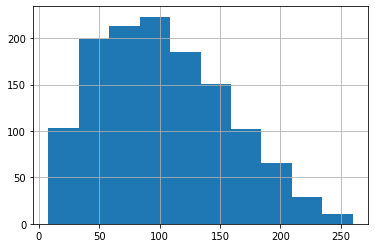

In [58]:
#histogram to display length of phrases in positive dataset
positive['Phrase'].str.len().hist()

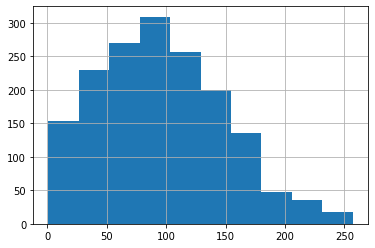

In [59]:
#histogram to display length of phrases in neutral dataset
neutral['Phrase'].str.len().hist()

## Data Preprocessing

In [60]:
#converting strings to lowercase in Phrase column
train['Phrase'] = train['Phrase'].str.lower() 

In [61]:
#preprocessing Phrases column of dataframe 

nltk.download('stopwords')
from nltk.corpus import stopwords 
import re
stop_words = set(stopwords.words('english')) 

#remove unusual characters and stop words
train['Phrase']= train['Phrase'].apply(lambda x: re.sub('[^A-Za-z0-9]+', ' ', x))
train['Phrase'] = train['Phrase'].apply(lambda x: " ".join(x for x in x.split() if x not in stop_words))
train

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,PhraseId,SentenceId,Phrase,Sentiment,Sentiment Label
0,1,1,series escapades demonstrating adage good goos...,1,Somewhat Negative
1,2,1,series escapades demonstrating adage good goose,2,Neutral
2,3,1,series,2,Neutral
3,4,1,,2,Neutral
4,5,1,series,2,Neutral
...,...,...,...,...,...
156055,156056,8544,hearst,2,Neutral
156056,156057,8544,forced avuncular chortles,1,Somewhat Negative
156057,156058,8544,avuncular chortles,3,Somewhat Positive
156058,156059,8544,avuncular,2,Neutral


In [62]:
#tokenize
#from textblob import TextBlob
train['Phrase'] = train['Phrase'].str.replace('[^\w\s]','')
train['Phrase'] = train['Phrase'].apply(word_tokenize)
train

,PhraseId,SentenceId,Phrase,Sentiment,Sentiment Label
0,1,1,"[series, escapades, demonstrating, adage, good...",1,Somewhat Negative
1,2,1,"[series, escapades, demonstrating, adage, good...",2,Neutral
2,3,1,[series],2,Neutral
3,4,1,[],2,Neutral
4,5,1,[series],2,Neutral
...,...,...,...,...,...
156055,156056,8544,[hearst],2,Neutral
156056,156057,8544,"[forced, avuncular, chortles]",1,Somewhat Negative
156057,156058,8544,"[avuncular, chortles]",3,Somewhat Positive
156058,156059,8544,[avuncular],2,Neutral


In [63]:
#lemmatize
#from textblob import Word

from nltk.stem import WordNetLemmatizer

def lemmatize(words):
    """Lemmatize verbs in list of tokenized words"""
    lemmatizer = WordNetLemmatizer()
    lemmas = []
    for word in words:
        lemma = lemmatizer.lemmatize(word, pos='v')
        lemmas.append(lemma)
    return lemmas


train['Phrase'] = train['Phrase'].apply(lemmatize) 
train


,PhraseId,SentenceId,Phrase,Sentiment,Sentiment Label
0,1,1,"[series, escapades, demonstrate, adage, good, ...",1,Somewhat Negative
1,2,1,"[series, escapades, demonstrate, adage, good, ...",2,Neutral
2,3,1,[series],2,Neutral
3,4,1,[],2,Neutral
4,5,1,[series],2,Neutral
...,...,...,...,...,...
156055,156056,8544,[hearst],2,Neutral
156056,156057,8544,"[force, avuncular, chortle]",1,Somewhat Negative
156057,156058,8544,"[avuncular, chortle]",3,Somewhat Positive
156058,156059,8544,[avuncular],2,Neutral


In [64]:
#vectorize
tfidf = TfidfVectorizer(preprocessor=' '.join, stop_words='english')
features = tfidf.fit_transform(train['Phrase'])
features.shape

(156060, 12349)

In [65]:
from imblearn.over_sampling import SMOTE
oversample = SMOTE()

X = features
Y = train['Sentiment'].values
X, Y = oversample.fit_resample(X, Y)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [66]:
#train test split

#stratified k-fold cross-validation will enforce the class distribution in each split of the data to match the distribution in the complete training dataset 
#https://machinelearningmastery.com/cross-validation-for-imbalanced-classification/ 

from sklearn.model_selection import StratifiedKFold
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=17)
#enumerate the splits and summarize the distributions
for train_ix, test_ix in kfold.split(X, Y):
	# select rows
	train_X, test_X = X[train_ix], X[test_ix]
	train_Y, test_Y = Y[train_ix], Y[test_ix]


##Multinomial Naive Bayes Classifier

In [67]:
# Multinomial Naive Bayes Classifier 
from sklearn.naive_bayes import MultinomialNB
clf = MultinomialNB()
clf.fit(train_X, train_Y)
y_pred = clf.predict(test_X)
print('Accuracy Score on Train data: {0:.3f}'.format(clf.score(train_X, train_Y)))
print('Accuracy Score on Test data: {0:.3f}'.format(clf.score(test_X, test_Y)))


Accuracy Score on Train data: 0.595
Accuracy Score on Test data: 0.572


In [68]:
from sklearn.metrics import classification_report
print(classification_report(test_Y, clf.predict(test_X)))

              precision    recall  f1-score   support

           0       0.63      0.76      0.69      7959
           1       0.53      0.51      0.52      7958
           2       0.50      0.36      0.42      7958
           3       0.52      0.48      0.50      7958
           4       0.63      0.75      0.68      7958

    accuracy                           0.57     39791
   macro avg       0.56      0.57      0.56     39791
weighted avg       0.56      0.57      0.56     39791



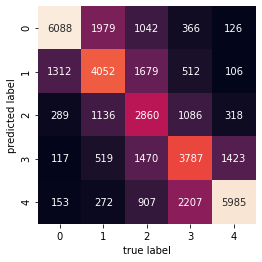

In [69]:
from sklearn.metrics import confusion_matrix
mat = confusion_matrix(test_Y, clf.predict(test_X))
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label');

In [70]:
#https://www.analyticsvidhya.com/blog/2020/06/auc-roc-curve-machine-learning/ 
pred_prob1 = clf.predict_proba(test_X)

In [71]:
from sklearn.metrics import roc_curve
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import roc_auc_score

# roc curve for models
fpr1, tpr1, thresh1 = roc_curve(test_Y, pred_prob1[:,1], pos_label=1)
random_probs = [0 for i in range(len(test_Y))]
p_fpr, p_tpr, _ = roc_curve(test_Y, random_probs, pos_label=1)

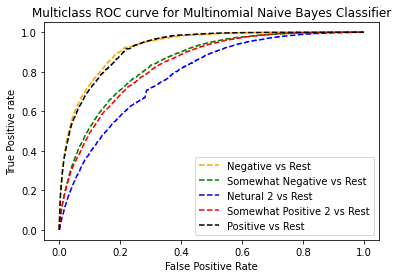

In [72]:
# plot roc curve for classes predicted by Multinomial Naive Bayes Classifier
fpr = {}
tpr = {}
thresh ={}

n_class = 5

for i in range(n_class):    
    fpr[i], tpr[i], thresh[i] = roc_curve(test_Y, pred_prob1[:,i], pos_label=i)
    
# plotting    
plt.plot(fpr[0], tpr[0], linestyle='--',color='orange', label='Negative vs Rest')
plt.plot(fpr[1], tpr[1], linestyle='--',color='green', label='Somewhat Negative vs Rest')
plt.plot(fpr[2], tpr[2], linestyle='--',color='blue', label='Netural 2 vs Rest')
plt.plot(fpr[3], tpr[3], linestyle='--',color='red', label='Somewhat Positive 2 vs Rest')
plt.plot(fpr[4], tpr[4], linestyle='--',color='black', label='Positive vs Rest')
plt.title('Multiclass ROC curve for Multinomial Naive Bayes Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend(loc='best')
plt.savefig('Multiclass ROC',dpi=300);    

In [73]:
roc_auc_score(test_Y, pred_prob1, multi_class='ovr')

0.862724465717265

##Logistic Regression##

In [74]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(solver = 'liblinear', C=10.0, max_iter=1000,)
lr.fit(train_X,train_Y)
y_pred1 = lr.predict(test_X)
pred_prob2 = lr.predict_proba(test_X)
print('Accuracy Score on Train data: {0:.3f}'.format(lr.score(train_X, train_Y)))
print('Accuracy Score on Test data: {0:.3f}'.format(lr.score(test_X, test_Y)))


Accuracy Score on Train data: 0.654
Accuracy Score on Test data: 0.622


In [75]:
#classification report for Logistic Regression
print(classification_report(test_Y, lr.predict(test_X)))

              precision    recall  f1-score   support

           0       0.72      0.77      0.75      7959
           1       0.63      0.56      0.59      7958
           2       0.48      0.52      0.50      7958
           3       0.60      0.52      0.56      7958
           4       0.68      0.74      0.71      7958

    accuracy                           0.62     39791
   macro avg       0.62      0.62      0.62     39791
weighted avg       0.62      0.62      0.62     39791



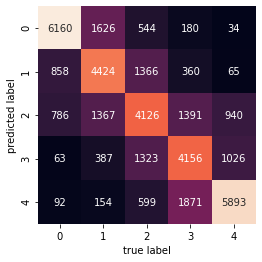

In [76]:
from sklearn.metrics import confusion_matrix
mat = confusion_matrix(test_Y, lr.predict(test_X))
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label');

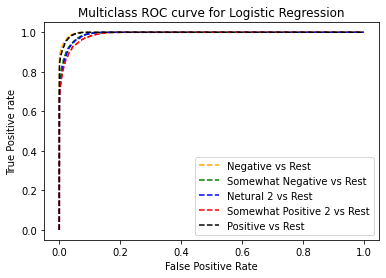

In [77]:
# plot roc curve for classes predicted by Logistic Regression
fpr = {}
tpr = {}
thresh ={}

n_class = 5

for i in range(n_class):    
    fpr[i], tpr[i], thresh[i] = roc_curve(y_pred1, pred_prob2[:,i], pos_label=i)
    
# plotting    
plt.plot(fpr[0], tpr[0], linestyle='--',color='orange', label='Negative vs Rest')
plt.plot(fpr[1], tpr[1], linestyle='--',color='green', label='Somewhat Negative vs Rest')
plt.plot(fpr[2], tpr[2], linestyle='--',color='blue', label='Netural 2 vs Rest')
plt.plot(fpr[3], tpr[3], linestyle='--',color='red', label='Somewhat Positive 2 vs Rest')
plt.plot(fpr[4], tpr[4], linestyle='--',color='black', label='Positive vs Rest')
plt.title('Multiclass ROC curve for Logistic Regression')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend(loc='best')
plt.savefig('Multiclass ROC',dpi=300);    

In [78]:
roc_auc_score(test_Y, pred_prob2, multi_class='ovr')

0.8853484445784986

##Support Vector Classifier

In [79]:
#Support Vector Classifier
from sklearn import svm
#set random state for reproducability 
lin_clf = svm.LinearSVC(multi_class='ovr', C=5.0)
lin_clf.fit(train_X,train_Y)

LinearSVC(C=5.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)

In [80]:
print('Accuracy Score on Train data: {0:.3f}'.format(lin_clf.score(train_X, train_Y)))
print('Accuracy Score on Test data: {0:.3f}'.format(lin_clf.score(test_X, test_Y)))

Accuracy Score on Train data: 0.652
Accuracy Score on Test data: 0.619


In [81]:
#classification report for Support Vector Classifier
from sklearn.metrics import classification_report
print(classification_report(test_Y, lin_clf.predict(test_X)))

              precision    recall  f1-score   support

           0       0.71      0.78      0.75      7959
           1       0.62      0.55      0.59      7958
           2       0.48      0.50      0.49      7958
           3       0.60      0.51      0.55      7958
           4       0.67      0.75      0.71      7958

    accuracy                           0.62     39791
   macro avg       0.62      0.62      0.62     39791
weighted avg       0.62      0.62      0.62     39791



## Pre-processing Test Data 

In [82]:
#print the test dataset to screen
test

,PhraseId,SentenceId,Phrase
0,156061,8545,An intermittently pleasing but mostly routine ...
1,156062,8545,An intermittently pleasing but mostly routine ...
2,156063,8545,An
3,156064,8545,intermittently pleasing but mostly routine effort
4,156065,8545,intermittently pleasing but mostly routine
...,...,...,...
66287,222348,11855,"A long-winded , predictable scenario ."
66288,222349,11855,"A long-winded , predictable scenario"
66289,222350,11855,"A long-winded ,"
66290,222351,11855,A long-winded


In [83]:
#owercase the Phrase column
test['Phrase'] = test['Phrase'].str.lower() 

In [84]:
#remove unusual characters and stop words
test['Phrase']= test['Phrase'].apply(lambda x: re.sub('[^A-Za-z0-9]+', ' ', x))
test['Phrase'] = test['Phrase'].apply(lambda x: " ".join(x for x in x.split() if x not in stop_words))
test

,PhraseId,SentenceId,Phrase
0,156061,8545,intermittently pleasing mostly routine effort
1,156062,8545,intermittently pleasing mostly routine effort
2,156063,8545,
3,156064,8545,intermittently pleasing mostly routine effort
4,156065,8545,intermittently pleasing mostly routine
...,...,...,...
66287,222348,11855,long winded predictable scenario
66288,222349,11855,long winded predictable scenario
66289,222350,11855,long winded
66290,222351,11855,long winded


In [85]:
#tokenize
test['Phrase'] = test['Phrase'].str.replace('[^\w\s]','')
test['Phrase'] = test['Phrase'].apply(word_tokenize)
test

,PhraseId,SentenceId,Phrase
0,156061,8545,"[intermittently, pleasing, mostly, routine, ef..."
1,156062,8545,"[intermittently, pleasing, mostly, routine, ef..."
2,156063,8545,[]
3,156064,8545,"[intermittently, pleasing, mostly, routine, ef..."
4,156065,8545,"[intermittently, pleasing, mostly, routine]"
...,...,...,...
66287,222348,11855,"[long, winded, predictable, scenario]"
66288,222349,11855,"[long, winded, predictable, scenario]"
66289,222350,11855,"[long, winded]"
66290,222351,11855,"[long, winded]"


In [86]:
#lemmatize
test['Phrase'] = test['Phrase'].apply(lemmatize) 
test

,PhraseId,SentenceId,Phrase
0,156061,8545,"[intermittently, please, mostly, routine, effort]"
1,156062,8545,"[intermittently, please, mostly, routine, effort]"
2,156063,8545,[]
3,156064,8545,"[intermittently, please, mostly, routine, effort]"
4,156065,8545,"[intermittently, please, mostly, routine]"
...,...,...,...
66287,222348,11855,"[long, wind, predictable, scenario]"
66288,222349,11855,"[long, wind, predictable, scenario]"
66289,222350,11855,"[long, wind]"
66290,222351,11855,"[long, wind]"


In [87]:
#fit function is not used on test data, transform function only is used to model predictions on established vocabulary of terms from training data
test_features = tfidf.transform(test['Phrase'])
#confirm size of test data and amount of features to match those model have been trained on
test_features.shape

(66292, 12349)

In [88]:
test

,PhraseId,SentenceId,Phrase
0,156061,8545,"[intermittently, please, mostly, routine, effort]"
1,156062,8545,"[intermittently, please, mostly, routine, effort]"
2,156063,8545,[]
3,156064,8545,"[intermittently, please, mostly, routine, effort]"
4,156065,8545,"[intermittently, please, mostly, routine]"
...,...,...,...
66287,222348,11855,"[long, wind, predictable, scenario]"
66288,222349,11855,"[long, wind, predictable, scenario]"
66289,222350,11855,"[long, wind]"
66290,222351,11855,"[long, wind]"


## Applying test data to Support Vector Classifier

In [89]:
#Predictions from SVC
predicted = lin_clf.predict(test_features)
results = pd.DataFrame(predicted)
results

,0
0,3
1,3
2,2
3,3
4,3
...,...
66287,1
66288,1
66289,0
66290,0


2    25171
3    13466
1    11572
4     9301
0     6782
dtype: int64

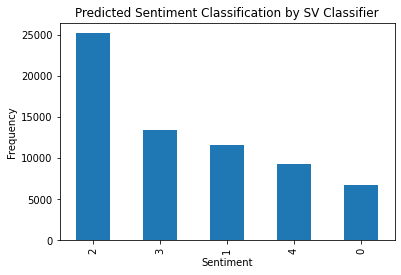

In [90]:
pd.value_counts(results[0]).plot.bar()
plt.title('Predicted Sentiment Classification by SV Classifier')
plt.xlabel('Sentiment')
plt.ylabel('Frequency')
results.value_counts()

##Applying test data to Logistic Regression Model ##

In [110]:
#Predictions from Logistic Regression Model
predicted1= lr.predict(test_features)
lr_results = pd.DataFrame(predicted1)
lr_results

,0
0,3
1,3
2,2
3,3
4,3
...,...
66287,1
66288,1
66289,0
66290,0


2    25855
3    13644
1    11615
4     8818
0     6360
dtype: int64

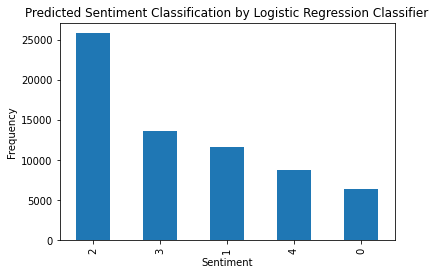

In [92]:
pd.value_counts(lr_results[0]).plot.bar()
plt.title('Predicted Sentiment Classification by Logistic Regression Classifier')
plt.xlabel('Sentiment')
plt.ylabel('Frequency')
lr_results.value_counts()

In [96]:
results.describe()

,0
count,66292.000000
mean,2.104568
std,1.156379
min,0.000000
25%,1.000000
50%,2.000000
75%,3.000000
max,4.000000


In [97]:
lr_results.describe()

,0
count,66292.000000
mean,2.104764
std,1.133974
min,0.000000
25%,1.000000
50%,2.000000
75%,3.000000
max,4.000000


##Performance Evaluation

In [113]:
#Non-Parametric Bootstrap Sampling for examining classifier performance
#https://towardsdatascience.com/evaluate-ml-classifier-performance-using-statistical-hypothesis-testing-in-python-e4b90eb27dce
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score
models = []
models.append(('LR', LogisticRegression(max_iter=1000))) 
models.append(('SVM', svm.LinearSVC()))
# evaluate each model in turn
results = []
names = []
for name, model in models:
    kfold = RepeatedStratifiedKFold(n_splits=10, n_repeats = 3, random_state=1)
    cv_results = cross_val_score(model, test_X, test_Y, cv=kfold, scoring='accuracy') 
    results.append(cv_results)
    names.append(name)
    msg = "%s: %.2f (%.3f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)


LR: 0.54 (0.008)
SVM: 0.55 (0.008)


Logistic Regression Accuracy: 54.5% +/-(0.008)
Support Vector Classifier Mean Accuracy: 55.2% +/-(0.008)


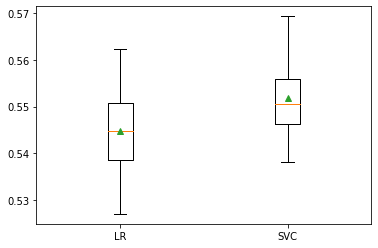

In [118]:
# evaluate model 1
model1 = LogisticRegression(max_iter=1000)
cv1 = RepeatedStratifiedKFold(n_splits = 10, n_repeats = 3, random_state = 1)
scores1 = cross_val_score(model1, test_X, test_Y, scoring = 'accuracy', cv = cv1, n_jobs = -1)
print('Logistic Regression Accuracy: %.1f%% +/-(%.3f)' % (np.mean(scores1*100), np.std(scores1)))
# evaluate model 2
model2 = svm.LinearSVC()
cv2 = RepeatedStratifiedKFold(n_splits = 10, n_repeats = 3, random_state = 1)
scores3 = cross_val_score(model2, test_X, test_Y, scoring = 'accuracy', cv = cv2, n_jobs = -1)
print('Support Vector Classifier Mean Accuracy: %.1f%% +/-(%.3f)' % (np.mean(scores3*100), np.std(scores3)))
# plot the results
plt.boxplot([scores1, scores3], labels=['LR', 'SVC'], showmeans=True)
plt.show()

In [119]:
from mlxtend.evaluate import paired_ttest_5x2cv
# check if difference between algorithms is real
t, p = paired_ttest_5x2cv(estimator1=model1, 
                          estimator2=model2, 
                          X=test_X, 
                          y=test_Y, 
                          scoring='accuracy', 
                          random_seed=1)
# summarize
print(f'The P-value is = {p:.3f}')
print(f'The t-statistics is = {t:.3f}')
# interpret the result
if p <= 0.05:
    print('Since p<0.05, We can reject the null-hypothesis that both models perform equally well on this dataset. We may conclude that the two algorithms are significantly different.')
else:
    print('Since p>0.05, we cannot reject the null hypothesis and may conclude that the performance of the two algorithms is not significantly different.')

The P-value is = 0.215
The t-statistics is = -1.421
Since p>0.05, we cannot reject the null hypothesis and may conclude that the performance of the two algorithms is not significantly different.
